In [511]:
%reset -f
import glob, os, sys, inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import pandas as pd
from wavhandler import *
from natsort import natsorted
from utils import *
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import io
import PIL
import seaborn as sns; sns.set()

np.random.seed(0)
plt.rcParams['figure.figsize'] = [24, 4]

import logging
logger = logging.getLogger()
logger.setLevel(logging.WARN)

def damping_ratio(freqs, ampls, peaks):
    try:
        fund_ampl = ampls[peaks[0]]
        fund_freq = freqs[peaks[0]]
    except:
        log.debug('No peaks detected')
        return 0
        
    peak_a, peak_b = peaks[0], peaks[0]

    while ampls[peak_a] > fund_ampl/2:
        peak_a+=1
    while ampls[peak_b] > fund_ampl/2:
        peak_b-=1

    omega_a, omega_b = freqs[peak_a], freqs[peak_b]
    damping = (omega_a - omega_b) / (2*fund_freq)
    return damping

# Example Raw Signal

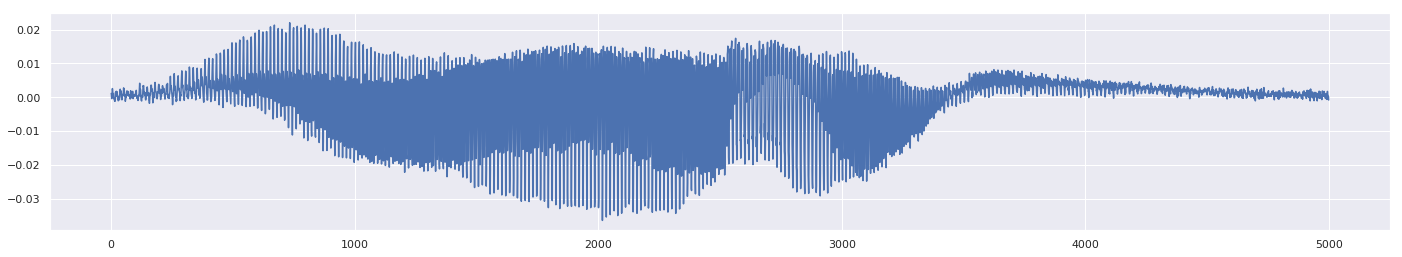

In [512]:
smpl = 1
z = WavHandler('/home/yannis/data/insects/Potamitis/Wingbeats/Aedes', sample_size=smpl, recursive=True)
z.read()
z.df_signals.iloc[:,0].plot()

# Signal after applying [75,1000] bandpass filter

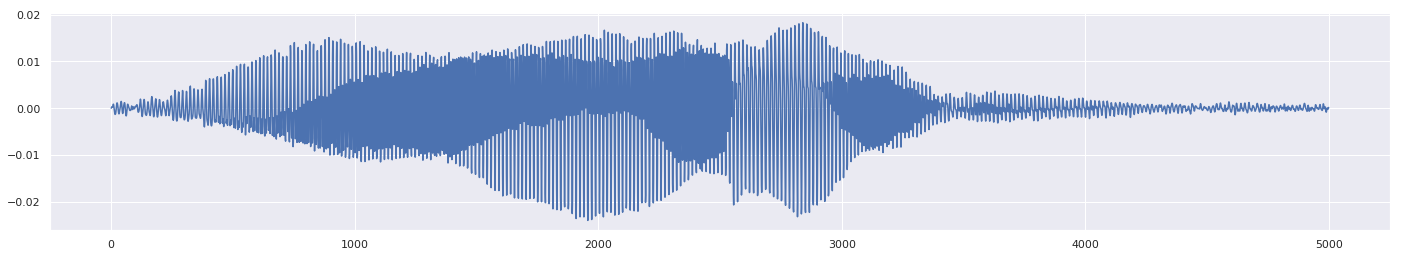

In [513]:
z.preprocess()
#z.filter_accepted_signals()
#print(len(z.accepted_signals))
z.df_signals.iloc[:,0].plot()

# Signal Cropping

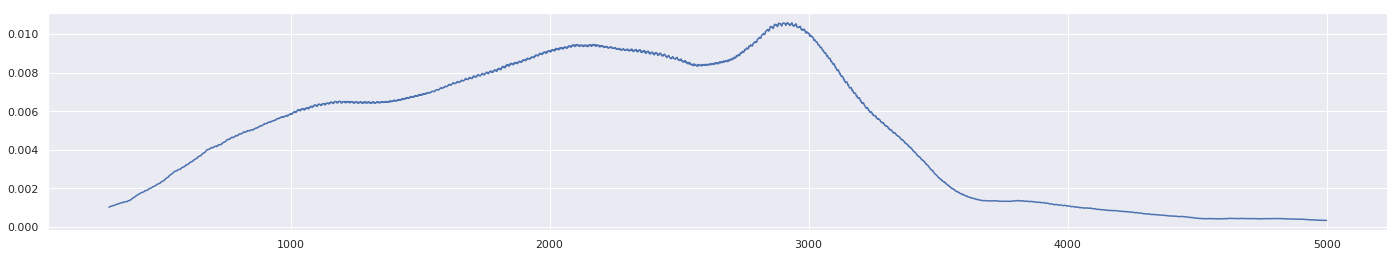

In [514]:
sig = z.df_signals.iloc[:,0]
sigseries = pd.Series(sig)
window = 300
rolling_mean = np.abs(sigseries).rolling(window).mean()
rolling_mean.plot()

## Thresholding

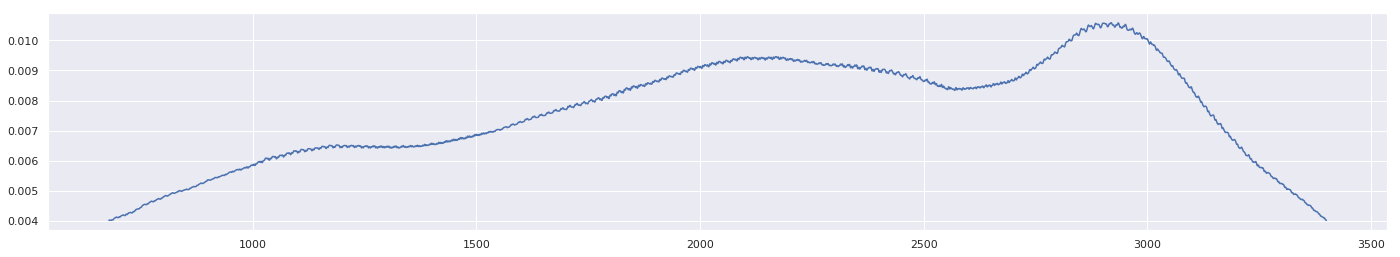

In [515]:
thd = 0.004
offset = 250

try:
    flag = 1
    rolling_mean[rolling_mean>thd].plot()
except:
    print('No values above threshold')
    flag = 0

0
428 3151


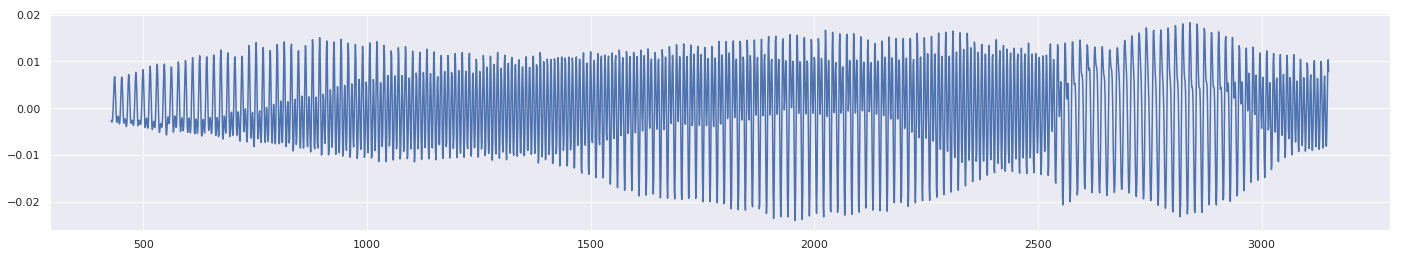

In [516]:
if flag ==1:
    qq = rolling_mean[rolling_mean>thd]
    import more_itertools as mit
    iterable = qq.index.tolist()
    ww = [list(group) for group in mit.consecutive_groups(iterable)]
    print(pd.Series([len(ww[i]) for i in range(len(ww))]).idxmax())
    print(ww[0][0]-offset, ww[0][-1]-offset)

    #sigseries.iloc[rolling_mean.idxmax()+1-window:rolling_mean.idxmax()+1].plot()
    sigseries.iloc[ww[0][0] - offset : ww[0][-1] - offset].plot()

    sig = sigseries.iloc[ww[0][0] -offset : ww[0][-1] -offset]

# Power Spectral Density (Welch's, Hamming window)

f.shape:  (4097,)
peakseries: 
 0    0.136271
Name: pows, dtype: float64
[1003.90625]
DAMPING RATIO: 0.023346303501945526

IS THIS SIGNAL ACCEPTED? ----> False


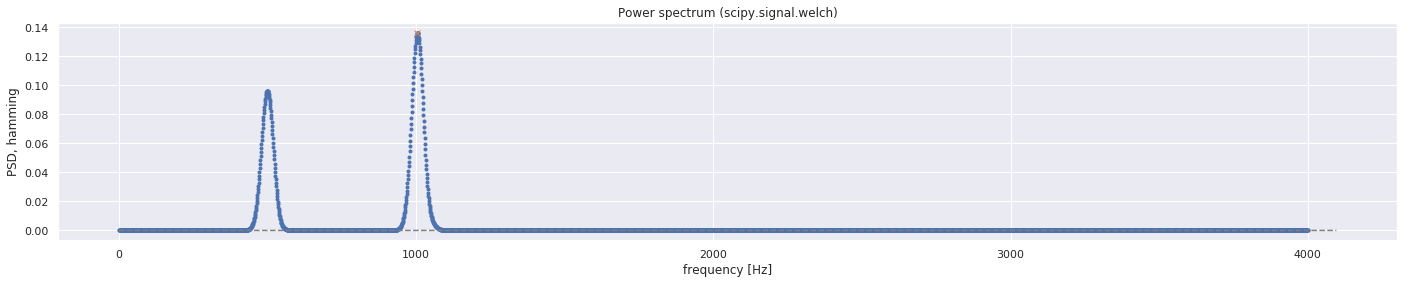

In [517]:
from sklearn.preprocessing import normalize
from scipy.signal import find_peaks

f, pows = signal.welch(sig, 8000., scaling='density', window='hamming',nfft=8192, noverlap=None)
print('f.shape: ', f.shape)

x = normalize(pows.reshape(-1,1), norm='l2', axis=0).reshape(-1,)
threshold = 0.1
peaks, vals = find_peaks(x, height=threshold, distance=10)
peaks = [v for i,v in enumerate(peaks) if f[peaks][i] > 300]
##############V#####
plt.plot(f,x,'.');plt.plot(f[peaks], x[peaks], "x");plt.plot(np.zeros_like(x), "--", color="gray")
plt.xlabel('frequency [Hz]');plt.ylabel('PSD, hamming');plt.title('Power spectrum (scipy.signal.welch)')

df = pd.DataFrame(np.vstack((f[peaks], x[peaks])).T, columns=['freqs','pows'])
peakseries = df['pows'].nlargest(10)
print('peakseries: \n',peakseries)
if peakseries.shape[0] == 2:
    # If there are 2 peaks, return True only if
    # the highest peak is larger than the threshold OR
    # the second highest peak is larger than the threshold
    condition = (peakseries.iloc[0] > threshold or peakseries.iloc[1] > threshold)
elif peakseries.shape[0] > 2:
    # If there are more peaks, return True if
    # the same as above AND
    # the leftmost peak is higher than the third peak (counting from the left) AND
    # the second peak from the left is also higher than the third peak
    condition = (peakseries.iloc[0] > threshold or peakseries.iloc[1] > threshold) and \
            (peakseries.loc[0] > peakseries.loc[2]) and \
            (peakseries.loc[1] > peakseries.loc[2])
else:
    condition = False
print(f[peaks])
print('DAMPING RATIO: {}'.format(damping_ratio(f, x, peaks)))
print("\nIS THIS SIGNAL ACCEPTED? ----> {}".format(condition))

# Spectrogram

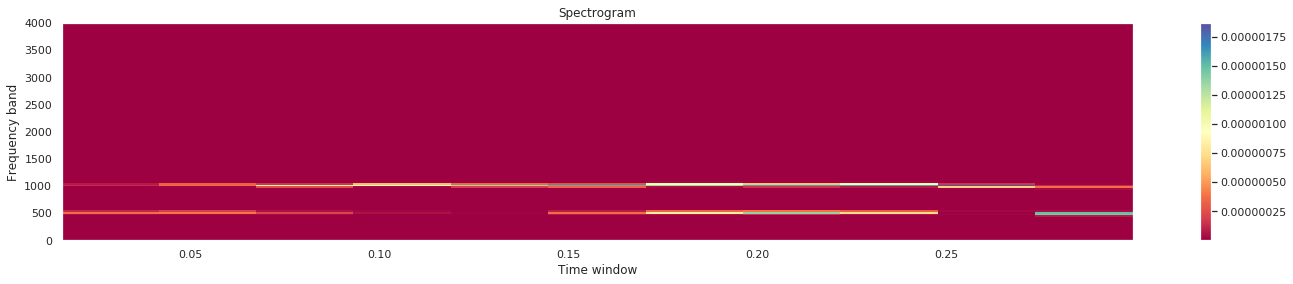

In [518]:
freqs, times, spectrogram = signal.spectrogram(sig, 8000., noverlap=50,window='hamming')
plt.title('Spectrogram')
plt.ylabel('Frequency band')
plt.xlabel('Time window')
#plt.imshow(spectrogram, aspect='auto', cmap='hot_r', origin='lower')

plt.pcolormesh(times, freqs, spectrogram, cmap='Spectral')
plt.colorbar()

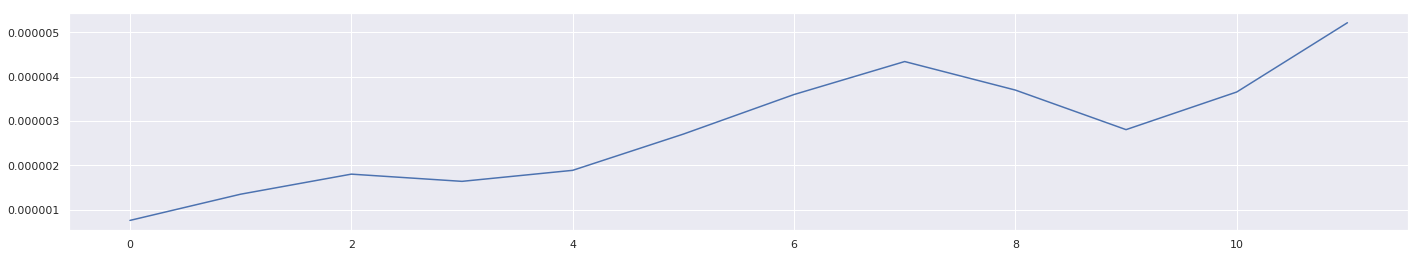

In [519]:
plt.plot(spectrogram.sum(axis=0))#, keepdims=True))


In [520]:
times, times.shape


(array([0.016  , 0.04175, 0.0675 , 0.09325, 0.119  , 0.14475, 0.1705 ,
        0.19625, 0.222  , 0.24775, 0.2735 , 0.29925]), (12,))

In [401]:
freqs,freqs.shape

(array([   0.  ,   31.25,   62.5 ,   93.75,  125.  ,  156.25,  187.5 ,
         218.75,  250.  ,  281.25,  312.5 ,  343.75,  375.  ,  406.25,
         437.5 ,  468.75,  500.  ,  531.25,  562.5 ,  593.75,  625.  ,
         656.25,  687.5 ,  718.75,  750.  ,  781.25,  812.5 ,  843.75,
         875.  ,  906.25,  937.5 ,  968.75, 1000.  , 1031.25, 1062.5 ,
        1093.75, 1125.  , 1156.25, 1187.5 , 1218.75, 1250.  , 1281.25,
        1312.5 , 1343.75, 1375.  , 1406.25, 1437.5 , 1468.75, 1500.  ,
        1531.25, 1562.5 , 1593.75, 1625.  , 1656.25, 1687.5 , 1718.75,
        1750.  , 1781.25, 1812.5 , 1843.75, 1875.  , 1906.25, 1937.5 ,
        1968.75, 2000.  , 2031.25, 2062.5 , 2093.75, 2125.  , 2156.25,
        2187.5 , 2218.75, 2250.  , 2281.25, 2312.5 , 2343.75, 2375.  ,
        2406.25, 2437.5 , 2468.75, 2500.  , 2531.25, 2562.5 , 2593.75,
        2625.  , 2656.25, 2687.5 , 2718.75, 2750.  , 2781.25, 2812.5 ,
        2843.75, 2875.  , 2906.25, 2937.5 , 2968.75, 3000.  , 3031.25,
      

In [78]:
spectrogram

array([[2.09321789e-12, 2.45433469e-12, 1.43465269e-13, ...,
        6.29493955e-14, 3.75396338e-13, 1.45689363e-12],
       [4.43630647e-12, 1.84432960e-12, 1.38655240e-12, ...,
        1.21316320e-12, 8.21641100e-13, 1.91776472e-12],
       [1.77140984e-11, 6.61918060e-11, 1.99410919e-11, ...,
        5.13017028e-11, 1.30387505e-11, 2.25808812e-12],
       ...,
       [2.02513606e-16, 1.11931489e-16, 1.52783513e-16, ...,
        1.61703470e-17, 7.31704396e-16, 7.71248703e-16],
       [2.02421087e-16, 1.11826907e-16, 1.52588775e-16, ...,
        1.61355547e-17, 7.31281425e-16, 7.70829487e-16],
       [1.01194928e-16, 5.58962567e-17, 7.62619463e-17, ...,
        8.06191356e-18, 3.65570398e-16, 3.85344565e-16]])

In [11]:
spectrogram.shape

(129, 24)